<a href="https://colab.research.google.com/github/Redwoods/Py/blob/master/pdm2020/my-note/pyz-NLP/NLP_ex03N_NAVER_biLSTM_Bahdanau_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP : 자연어 처리 - Naver 영화 리뷰 감성 분류
- 양방향 LSTM과 어텐션 메커니즘을 이용한 감성 분류기
- > (BiLSTM with Attention mechanism)

## 한국어/한글 데이터
- 네이버 영화 리뷰 데이터: 200,000개 리뷰 
    - 0: 부정
    - 1: 긍정
- 한국어 데이터는 토큰화(tokenization)를 할 때 형태소 분석기를 사용

---

## 네이버 영화 리뷰 데이터 전처리

> 토큰화를 위한 형태소 분석기는 KoNLPy의 Okt를 사용
- Okt: KoNLPy에서 제공하는 형태소 분석기

> JAVA_PATH 설정
- pip install jpype1
- PATH 추가 : %JAVA_HOME%\bin\

In [ ]:
# !pip install konlpy

In [ ]:
from konlpy.tag import Okt

In [ ]:
# Okt 예제
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)


['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Load data
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
train_data.shape,test_data.shape

((150000, 3), (50000, 3))

In [ ]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [ ]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- 데이터는 id, document, label 총 3개의 열로 구성 
- id는 감성 분류를 수행하는데 도움이 되지 않으므로 앞으로 무시
- 리뷰 내용을 담고있는 document
- 해당 리뷰가 긍정(1), 부정(0)인지를 나타내는 label 

In [ ]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력
test_data[:5]

테스트용 리뷰 개수 : 50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


### Preprocessing data

### train_data

In [ ]:
# train_data, 데이터에 중복이 있지는 않은지 확인
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

> 총 150,000개의 샘플이 존재하는데 document열에서 중복을 제거한 샘플의 개수가 146,182개라는 것은 약 4,000개의 중복 샘플이 존재

In [ ]:
# 중복 샘플을 제거
train_data.drop_duplicates(subset=['document'], inplace=True) 
# document 열에서 중복인 내용이 있다면 중복 제거

# 중복 샘플을 제거 gn, 전체 샘플 수를 확인.
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


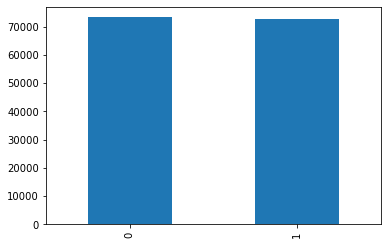

In [ ]:
# train_data에서 해당 리뷰의 긍, 부정 유무를 의미하는 레이블 값의 분포를 시각화
train_data['label'].value_counts().plot(kind='bar');

In [ ]:
#  레이블 값의 분포를 수치로 확인
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


In [ ]:
#  Null 값을 가진 샘플 검사
train_data.isnull().values.any()

True

In [ ]:
train_data.isnull().sum() #axis=0)

id          0
document    1
label       0
dtype: int64

> 리뷰가 적혀있는 document 열에서 Null 값을 가진 샘플이 총 1개가 존재한다고 합니다. 그렇다면 document 열에서 Null 값이 존재한다는 것을 조건으로 Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 한 번 출력

In [ ]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [ ]:
# train_data에서 Null 값을 가진 샘플을 제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
# 샘플의 개수를 출력하여 1개의 샘플이 제거되었는지 확인
print(len(train_data))

False
146182


### test_data

In [ ]:
# test_data, 데이터에 중복이 있지는 않은지 확인
test_data['document'].nunique(), test_data['label'].nunique()

(49157, 2)

> 총 50,000개의 샘플이 존재하는데 document열에서 중복을 제거한 샘플의 개수가 49,157라는 것은 843개의 중복 샘플이 존재

In [ ]:
# 중복 샘플을 제거
test_data.drop_duplicates(subset=['document'], inplace=True) 
# document 열에서 중복인 내용이 있다면 중복 제거

# 중복 샘플을 제거 후, 전체 샘플 수를 확인.
print('총 샘플의 수 :',len(test_data))

총 샘플의 수 : 49158


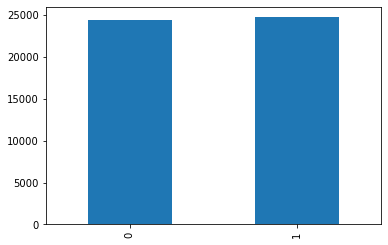

In [ ]:
# test_data 해당 리뷰의 긍, 부정 유무를 의미하는 레이블 값의 분포를 시각화
test_data['label'].value_counts().plot(kind='bar');

In [ ]:
#  레이블 값의 분포를 수치로 확인
print(test_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  24446
1      1  24712


In [ ]:
#  Null 값을 가진 샘플 검사
test_data.isnull().values.any()

True

In [ ]:
test_data.isnull().sum() #axis=0)

id          0
document    1
label       0
dtype: int64

> 리뷰가 적혀있는 document 열에서 Null 값을 가진 샘플이 총 1개가 존재한다고 합니다. 그렇다면 document 열에서 Null 값이 존재한다는 것을 조건으로 Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 한 번 출력

In [ ]:
test_data.loc[test_data.document.isnull()]

,id,document,label
5746,402110,NaN,1


In [ ]:
# test_data Null 값을 가진 샘플을 제거
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인
# 샘플의 개수를 출력하여 1개의 샘플이 제거되었는지 확인
print(len(test_data))

False
49157


## 한글 처리 (정규식 이용)
- 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행

In [ ]:
# train_data에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

<ipython-input-31-8f0cb5df4a03>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


- 네이버 영화 리뷰는 굳이 한글이 아니라 영어, 숫자, 특수문자로도 리뷰를 업로드할 수 있습니다.
> 기존에 한글이 없는 리뷰였다면 이제 더 이상 아무런 값도 없는 빈(empty) 값이 되었을 것입니다. train_data에 공백(white space)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, 다시 한 번 Null 값이 존재하는지 확인

In [ ]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

<ipython-input-32-c2f9538d5bc3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


id            0
document    789
label         0
dtype: int64


In [ ]:
# Null 값이 789개나 새로 생겼습니다. Null 값이 있는 행을 5개만 출력
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


> Null 샘플들은 레이블이 긍정일 수도 있고, 부정일 수도 있습니다. 사실 아무런 의미도 없는 데이터므로 제거

In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [ ]:
# 테스트 데이터에 지금까지 진행했던 전처리 과정들을 동일하게 진행
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


<ipython-input-35-a88a11e12978>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-35-a88a11e12978>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


## 토큰화
- 토큰화 과정에서 불용어를 제거
    - 한국어의 조사, 접속사 등이 보편적인 불용어


In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

> stem = True를 사용하면 일정 수준의 정규화를 수행해주는데, 예를 들어 위의 예제의 결과를 보면 '이런'이 '이렇다'로 변환되었고 '만드는'이 '만들다'로 변환된 것을 알 수 있습니다.

## 데이터 만들기

### 토큰화, 불용어 제거
 train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장

In [ ]:
X_train = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

# 상위 3개의 샘플만 출력
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [ ]:
# test_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장
X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

# 상위 3개의 샘플만 출력
print(X_test[:3])

[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]


### 정수 
- 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행

In [ ]:
# 훈련 데이터에 대해서 단어 집합(vocaburary) 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여
print(dict(list(tokenizer.word_index.items())[:5]))
print(dict(list(tokenizer.word_index.items())[-5:]))

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5}
{'ㅍㄹㄱ': 43748, '섹귀들': 43749, '찎었': 43750, '디케이드': 43751, '수간': 43752}


>  각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미

In [ ]:
# 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다. 
# 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인.
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


> 등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.87%밖에 되지 않습니다. 아무래도 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 그래서 이 단어들은 정수 인코딩 과정에서 배제합니다.

In [ ]:
# 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 
# 단어 집합의 최대 크기로 제한
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [ ]:
# 재토큰화
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# 정수 인코딩이 진행되었는지 확인
print(X_train[:3])
print(X_test[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]
[[746, 88], [59, 162, 26, 428, 19, 20, 295, 880, 46, 785, 18], [65, 19, 86, 337, 109, 104, 62, 149, 275]]


In [ ]:
type(X_train), max(max(X_train)), max(max(X_test))

(list, 19412, 19402)

In [ ]:
#  y_train과 y_test
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])
y_train.shape,y_test.shape

((145393,), (48852,))

### 빈 샘플(empty samples) 제거
- 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다
- 빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거

In [ ]:
# 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# drop_train에는 X_train으로부터 얻은 빈 샘플들의 인덱스가 저장

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145162
145162


C:\Users\life21c\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
type(X_train), X_train.shape

(numpy.ndarray, (145162,))

### 패딩 (0으로 패딩)
- 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


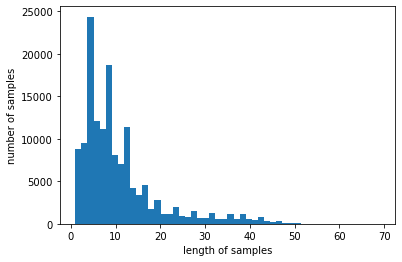

In [ ]:
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

> 가장 긴 리뷰의 길이는 69이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 11내외의 길이를 가지는 것을 볼 수 있습니다. 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 
- 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 


In [ ]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))


In [ ]:
# 위의 분포 그래프를 봤을 때, max_len = 30이 적당할 것 같습니다. 
# 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [ ]:
# Padded data
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)
X_train.shape,X_test.shape

((145162, 30), (48852, 30))

## 바다나우 어텐션(Bahdanau Attention)
- 텍스트 분류에서 어텐션 메커니즘을 사용하는 이유는 무엇일까요? 
- >RNN의 마지막 은닉 상태는 예측을 위해 사용됩니다. 그런데 이 RNN의 마지막 은닉 상태는 몇 가지 유용한 정보들을 손실한 상태입니다. 그래서 RNN이 time step을 지나며 손실했던 정보들을 다시 참고하고자 합니다.
- 다시 말해 RNN의 모든 은닉 상태들을 다시 한 번 참고하겠다는 것입니다. 그리고 이를 위해서 어텐션메커니즘을 사용합니다.

In [ ]:
import tensorflow as tf

In [ ]:
# BahdanauAttention
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

## 양방향 LSTM + 어텐션 메커니즘
- BiLSTM with Attention Mechanism

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

### Model
1. 입력층과 임베딩층을 설계
2. 양방향 LSTM을 설계 + Attention
3. 밀집층 + 최종 출력층

In [ ]:
# 입력층과 임베딩층을 설계 
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

In [ ]:
# 양방향 LSTM을 설계
# 첫번째 층
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)
# 두번째 층을 위에 쌓을 예정이므로 return_sequences를 True
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)
# 상태를 리턴받아야 하므로 return_state를 True

In [ ]:
# 각 상태의 크기(shape)를 출력
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 30, 128) (None, 64) (None, 64) (None, 64) (None, 64)


> 순방향 LSTM의 은닉 상태와 셀상태를 forward_h, forward_c에 저장하고, 역방향 LSTM의 은닉 상태와 셀 상태를 backward_h, backward_c에 저장

In [ ]:
# 양방향 LSTM을 사용할 경우에는 순방향 LSTM과 역방향 LSTM 각각 은닉 상태와 셀 상태를 가지므로, 
# 양방향 LSTM의 은닉 상태와 셀 상태를 사용하려면 두 방향의 LSTM의 상태들을 연결(concatenate)
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [ ]:
# 어텐션 메커니즘에서는 은닉 상태를 사용합니다. 
# 이를 입력으로 컨텍스트 벡터(context vector)를 얻습니다.
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

In [ ]:
# 컨텍스트 벡터를 밀집층(dense layer)에 통과시키고, 
# 이진 분류이므로 최종 출력층에 1개의 뉴런을 배치하고, 
# 활성화 함수로 시그모이드 함수를 사용
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)

In [ ]:
# 옵티마이저로 아담 옵티마이저 사용하고, 모델을 컴파일
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('./models/best_model_Naver_biLSTM_Attn.{epoch:02d}-{val_acc:.3f}.h5', 
                        monitor = 'val_acc', mode = 'max', 
                        verbose = 1, save_best_only = True)

In [ ]:
# Training
history = model.fit(X_train, y_train, 
                    epochs = 5, batch_size = 64, 
                    validation_data=(X_test, y_test), 
                    verbose = 1)
                    # callbacks=[es, mc])

Epoch 1/5
2269/2269 [==============================] - 1871s 814ms/step - loss: 0.4139 - acc: 0.8197 - val_loss: 0.3680 - val_acc: 0.8401
Epoch 2/5
2269/2269 [==============================] - 1834s 808ms/step - loss: 0.3595 - acc: 0.8503 - val_loss: 0.3584 - val_acc: 0.8508
Epoch 3/5
2269/2269 [==============================] - 1825s 804ms/step - loss: 0.3378 - acc: 0.8623 - val_loss: 0.3434 - val_acc: 0.8522
Epoch 4/5
2269/2269 [==============================] - 1844s 813ms/step - loss: 0.3243 - acc: 0.8702 - val_loss: 0.3436 - val_acc: 0.8534
Epoch 5/5
2269/2269 [==============================] - 1869s 824ms/step - loss: 0.3150 - acc: 0.8744 - val_loss: 0.3474 - val_acc: 0.8561


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 94s 61ms/step - loss: 0.3474 - acc: 0.8561

 테스트 정확도: 0.8561


- model.save() Problem
> https://medium.com/deep-learning-with-keras/save-load-keras-models-with-custom-layers-8f55ba9183d2

In [ ]:
model.save_weights('model_weights.h5') 

In [ ]:
tf.keras.models.save_model(model, 'best_model_Naver_biLSTM_Attn_vacc_8561.h5')

NotImplementedError: 

In [ ]:
model.save('best_model_Naver_biLSTM_Attn_vacc_8561.h5',save_format='tf')

NotImplementedError: 

---

> 위 모델을 IMDB 영화 리뷰 분류하기에도 수행해보세요. IMDB 영화 리뷰 분류하기에 위 모델을 그대로 적용하였을 때, 87.9%의 정확도를 얻었습니다.

## Summary 
- best model 비교

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
X_test.shape,y_test.shape

((48852, 30), (48852,))

In [ ]:
X_test[:3],y_test[:3]

(array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0, 746,  88],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,  59, 162,  26, 428,  19,  20, 295,
         880,  46, 785,  18],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,  65,  19,  86, 337, 109,
         104,  62, 149, 275]]),
 array([1, 0, 0], dtype=int64))

In [ ]:
# 훈련 과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델을 이용한 예측
loaded_model_lstm = load_model('./models/best_model_Naver_LSTM.04-0.858.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

OSError: SavedModel file does not exist at: ./models/best_model_Naver_LSTM.04-0.858.h5\{saved_model.pbtxt|saved_model.pb}

In [ ]:
# The best model of LSTM

model_best_naver_lstm = load_model('./models/best_model_Naver_LSTM.04-0.858.h5')
lstm_pred_Best = np.round(model_best_naver_lstm.predict(X_test))  #.astype(int)
print('Results for the Best LSTM Model for movie riview from naver')
print(np.round(accuracy_score(y_test, lstm_pred_Best),2),'%')
print(classification_report(y_test, lstm_pred_Best))

In [ ]:
# 훈련 과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델을 이용한 예측
loaded_model_d1cnn = load_model('./models/best_model_Naver_multi-D1CNN.03-0.851.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model_d1cnn.evaluate(X_test, y_test)[1]))

In [ ]:
# The best model of D1CNN
model_best_naver_d1cnn = load_model('./models/best_model_Naver_multi-D1CNN.03-0.851.h5')  
d1cnn_pred_Best = np.round(model_best_naver_d1cnn.predict(X_test)) #.astype(int)
print('Results for the Best D1 CNN Model for movie riview from naver')
print(np.round(accuracy_score(y_test, d1cnn_pred_Best),2),'%')
print(classification_report(y_test, d1cnn_pred_Best))

---

In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ',model_best_naver_lstm)
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ',model_best_naver_d1cnn)

In [ ]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ',model_best_naver_lstm)
sentiment_predict('이 영화 핵노잼 ㅠㅠ',model_best_naver_d1cnn)

In [ ]:
sentiment_predict('이딴게 영화냐 ㅉㅉ',model_best_naver_lstm)
sentiment_predict('이딴게 영화냐 ㅉㅉ',model_best_naver_d1cnn)

In [ ]:
sentiment_predict('감독 뭐하는 놈이냐?',model_best_naver_lstm)
sentiment_predict('감독 뭐하는 놈이냐?',model_best_naver_d1cnn)

In [ ]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다',model_best_naver_lstm)
sentiment_predict('ㄹㅇ, 재미 만땅',model_best_naver_lstm)
sentiment_predict('ㄹㅇ, 재미',model_best_naver_lstm)

In [ ]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다',model_best_naver_d1cnn)
sentiment_predict('ㄹㅇ, 재미 만땅',model_best_naver_d1cnn)
sentiment_predict('ㄹㅇ, 재미',model_best_naver_d1cnn)

---